In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from google.colab import drive
import zipfile

In the above cell we are importing all the necessary libraries that will be need in the execution of below model.

This code mounts Google Drive in Colab, we specify the path to a ZIP file, it creates an output directory and extracts the contents of the ZIP file to the output directory, and prints a success message.

In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')
zip_path = '/content/gdrive/MyDrive/PR/lfw.zip'
output_path = '/content/lfwdata/'

os.makedirs(output_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

print(f"Zip file '{zip_path}' has been successfully extracted to '{output_path}'.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Zip file '/content/gdrive/MyDrive/PR/lfw.zip' has been successfully extracted to '/content/lfwdata/'.


In [3]:
path = '/content/lfwdata/lfw'

Images are transformed into tensors using the code, which defines a PyTorch data transformation pipeline (transforms.Compose). Next, it creates a batch size of 32 and enables shuffle during the data loading process, creating a data loader (DataLoader) for the given image folder (ImageFolder).


In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This code checks if a GPU (cuda) is available; if so, it assigns the device to CUDA, otherwise, it assigns it to CPU. It then prints the selected device.

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


In this step, to describe the picture means that suppose we have (250, 250 , 3) size of image it means that its height and width are 250 while its is a RGB color base as it has 3 channels

torch.Size([250, 250, 3])


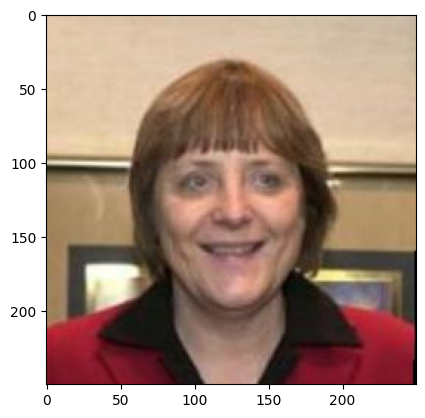

In [8]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

STEP 2:

The latent space layer that we use is a very important as a extra layer in a variational autoencoder (VAE) as opposed to a standard autoencoder. The mean and variance parameters that depict the latent space's probability distribution are produced by the latent space layer.

The essential elements consist of:

The mean (μ) layer produces the distribution's mean.
The variance (σ) layer produces the distribution's log variance, ensuring that the output is unconstrained.



During the training phase, these layers usually employ the reparameterization trick to efficiently sample from the distribution. Taking a sample from a unit Gaussian and transforming it using the mean and standard deviation is the reparameterization trick.





Using a deterministic latent space, autoencoders are frequently employed for tasks like compression and denoising. On the other hand, variational autoencoders, which use a probabilistic latent space, are better at producing a variety of samples and investigating the latent space distribution, which makes them appropriate for uses such as image generation. To shape the latent space distribution, VAEs use a specialised loss function that consists of a regularisation term in addition to reconstruction loss.
In order to mould the latent space distribution, VAEs use a unique loss function that combines a regularisation term and reconstruction loss.







In [9]:
#Step 3

import torch.nn.functional as F

# VAE class
class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)

        # Calculate the size after convolution
        self.conv_size = self._get_conv_size((3, 250, 250))

        # Latent space layers
        self.fc_mu = nn.Linear(self.conv_size, latent_dim)
        self.fc_logvar = nn.Linear(self.conv_size, latent_dim)

        # Decoder Layers
        self.dec_fc = nn.Linear(latent_dim, 128 * 1 * 1)  # Adjusted to match the desired size
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.dec_upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.dec_upsample4 = nn.Upsample(size=(250, 250), mode='bilinear', align_corners=True)
        self.dec_conv4 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1)



    def _get_conv_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self._forward_encoder(x)
            return x.view(1, -1).size(1)

    def _forward_encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        return x

    def encoder(self, x):
        x = self._forward_encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decoder(self, x):
        x = self.dec_fc(x)
        x = x.view(-1, 128, 1, 1)
        x = F.relu(self.dec_conv1(x))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_conv2(x))
        x = self.dec_upsample3(x)
        x = F.relu(self.dec_conv3(x))
        x = self.dec_upsample4(x)
        x = torch.sigmoid(self.dec_conv4(x))
        return x


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar


STEP 3 Description


1.__init__(self, latent_dim=256):

Initializes the VAE model with specified latent dimension.
Defines layers for encoder (convolutional), latent space (fully connected), and decoder (convolutional and upsampling).

2._get_conv_size(self, shape):

Determines the size after convolutional operations by passing a dummy tensor through the encoder layers and flattening the output.

3._forward_encoder(self, x):

Performs forward pass through the encoder convolutional layers with ReLU activation.

4.encoder(self, x):

Encodes input data through the encoder layers and returns mean (mu) and log variance (logvar) of the latent space.

5.decoder(self, x):

Decodes latent space representation through decoder layers with upsampling and convolutional operations.
Applies ReLU activation and sigmoid activation for the final output.

6.reparameterize(self, mu, logvar):

Applies the reparameterization trick to sample from the latent space distribution during training.

7.forward(self, x):

Performs the full forward pass of the VAE model.
Encodes input (x) to obtain mean and log variance, reparameterizes to get the latent space representation, and decodes to reconstruct the input.



**STEP 4**

Define Latent Dimension:
First we specify the size of the latent space.


Instantiate VAE Model:
We creates an instance of the VAE model with the specified latent dimension and move it to the target device.


Load and Preprocess Sample Image:
We loads an image, apply necessary transformations, and move it to the device.


Encode Sample Image:
We Pass the sample image through the VAE encoder to obtain mean (encoded_mu) and log variance (encoded_logvar) of the latent space.



Reparameterization Trick:

Apply the reparameterization trick to generate a sampled latent representation (sampled_latent) from the learned distribution in the latent space.



Re-encode Sample Image for Comparison:
Then we re-encode the sample image for comparison purposes.



Print Shapes of Encoded Mean and Log Variance:
we then print the shapes of the encoded mean and log variance for verification.

Decode Sampled Latent Representation:
Passes the sampled latent representation through the VAE decoder to generate a new image.

Print Shape of Generated Image:
Prints the shape of the generated image for confirmation.

In [10]:
from torchvision import transforms
from PIL import Image

# Define latent_dim
latent_dim = 256


vae_model = VAE(latent_dim)
vae_model = vae_model.to(device)

# Loading a sample image
sample_image = Image.open("/content/lfwdata/lfw/AJ_Cook/AJ_Cook_0001.jpg")
sample_image = transform(sample_image).unsqueeze(0)
sample_image = sample_image.to(device)

# Passing the image through the VAE model
with torch.no_grad():
    encoded_mu, encoded_logvar = vae_model.encoder(sample_image)

# Reparameterization trick to sample from the latent space
sampled_latent = vae_model.reparameterize(encoded_mu, encoded_logvar)

# Pass the image through the VAE model
with torch.no_grad():
    encoded_mu, encoded_logvar = vae_model.encoder(sample_image)

print("Encoded Mu Shape:", encoded_mu.shape)
print("Encoded Logvar Shape:", encoded_logvar.shape)

# Pass the sampled latent representation through the decoder
with torch.no_grad():
    generated_image = vae_model.decoder(sampled_latent)

# Print the shape of the generated image
print("Generated Image Shape:", generated_image.shape)



Encoded Mu Shape: torch.Size([1, 256])
Encoded Logvar Shape: torch.Size([1, 256])
Generated Image Shape: torch.Size([1, 3, 250, 250])


When it comes to generating new samples, the reparameterization trick steps in. Instead of directly sampling from the learned distribution, we tap into a standard normal distribution (N(0, 1)). Here's the trick: we then transform these samples to match the parameters of our learned distribution. This ensures that we can train our model seamlessly using gradient descent while keeping things differentiable.



In essence, we're playing with randomness in a controlled way. Sampling from a standard normal distribution and cleverly transforming those samples using mean and log variance allows our VAE to learn and generate a rich variety of samples, capturing the inherent uncertainty in the data.







In [11]:
#printing total number of parameters
total_params = sum(p.numel() for p in vae_model.parameters())
print("Total Parameters: ", total_params)


Total Parameters:  67332835


In [12]:
# Before training loop
torch.cuda.empty_cache()

# Hyperparameters
latent_dim = 30
learning_rate = 0.001
num_epochs = 15


# Defining the optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch, _ in dataloader:
        input_data = batch.to(device)

        # Forward pass
        output_data, mu, logvar = vae_model(input_data)

        # Calculate the loss
        reconstruction_loss = F.mse_loss(output_data, input_data, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = reconstruction_loss + kl_divergence

        # Backward pass and optimization step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item()}')
    print(f'Reconstruction Loss: {reconstruction_loss.item()}, KL Divergence: {kl_divergence.item()}')




Epoch [1/15], Loss: 198641.65625
Reconstruction Loss: 196510.71875, KL Divergence: 2130.936767578125
Epoch [2/15], Loss: 163367.078125
Reconstruction Loss: 160785.796875, KL Divergence: 2581.282470703125
Epoch [3/15], Loss: 178235.234375
Reconstruction Loss: 175855.40625, KL Divergence: 2379.822021484375
Epoch [4/15], Loss: 147868.515625
Reconstruction Loss: 145150.34375, KL Divergence: 2718.1708984375
Epoch [5/15], Loss: 156512.90625
Reconstruction Loss: 153703.140625, KL Divergence: 2809.759765625
Epoch [6/15], Loss: 156098.953125
Reconstruction Loss: 153598.734375, KL Divergence: 2500.22607421875
Epoch [7/15], Loss: 151169.03125
Reconstruction Loss: 148563.640625, KL Divergence: 2605.388671875
Epoch [8/15], Loss: 183651.609375
Reconstruction Loss: 181154.296875, KL Divergence: 2497.3125
Epoch [9/15], Loss: 152118.953125
Reconstruction Loss: 149442.03125, KL Divergence: 2676.921875
Epoch [10/15], Loss: 133553.96875
Reconstruction Loss: 131099.140625, KL Divergence: 2454.835205078125


STEP 5

Reconstruction Loss:

Explanation: Measures the difference between generated output and actual input for faithful reconstruction.
Importance: Ensures accurate model learning and faithful data reconstruction.
KL Divergence Term:

Explanation: Penalizes deviation of the latent space distribution from a standard normal distribution.
Importance: Encourages a well-behaved latent space, preventing overfitting and promoting meaningful representations.
Total Loss:

Explanation: Sum of reconstruction loss and KL divergence.
Importance: Balances accurate reconstruction with maintaining a structured latent space during training.










The total loss is what the model aims to minimize during training. By combining the reconstruction loss and the KL divergence, the VAE optimizes its parameters to both faithfully reconstruct input data and maintain a well-organized latent space. This dual objective ensures that the VAE not only generates realistic samples but also learns a useful and continuous representation of the data in the latent space.





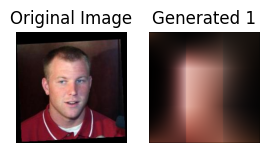

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Choose a random image from the dataset
random_index = np.random.randint(len(dataloader.dataset))
original_image, _ = dataloader.dataset[random_index]

# Move the original image to the GPU
original_image = original_image.to(device)

# Move the VAE model to the GPU if it's not already there
vae_model = vae_model.to(device)

# Pass the original image through the trained VAE model
with torch.no_grad():
    _, mu, logvar = vae_model(original_image.unsqueeze(0))

# Sample latent vectors from a normal distribution
std_dev = torch.exp(0.5 * logvar)
eps = torch.randn_like(std_dev)
sampled_latent = mu + eps * std_dev

# Decode the sampled latent vectors to generate new images
generated_samples = vae_model.decoder(sampled_latent)

# Convert tensors to NumPy arrays and adjust the channel dimension
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
generated_samples_np = [sample.squeeze(0).permute(1, 2, 0).cpu().detach().numpy() for sample in generated_samples]

# Plot the original image and generated samples
plt.figure(figsize=(10, 4))

# Original Image
plt.subplot(1, 6, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

# Generated Samples
for i, sample_np in enumerate(generated_samples_np, 2):
    plt.subplot(1, 6, i)
    plt.title(f"Generated {i-1}")
    plt.imshow(sample_np)
    plt.axis('off')

plt.show()


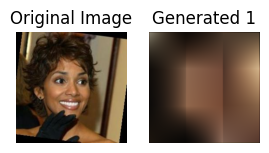

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Choose a random image from the dataset
random_index = np.random.randint(len(dataloader.dataset))
original_image, _ = dataloader.dataset[random_index]

# Move the original image to the GPU
original_image = original_image.to(device)

# Move the VAE model to the GPU if it's not already there
vae_model = vae_model.to(device)

# Pass the original image through the trained VAE model
with torch.no_grad():
    _, mu, logvar = vae_model(original_image.unsqueeze(0))

# Sample latent vectors from a normal distribution
std_dev = torch.exp(0.5 * logvar)
eps = torch.randn_like(std_dev)
sampled_latent = mu + eps * std_dev

# Decode the sampled latent vectors to generate new images
generated_samples = vae_model.decoder(sampled_latent)

# Convert tensors to NumPy arrays and adjust the channel dimension
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
generated_samples_np = [sample.squeeze(0).permute(1, 2, 0).cpu().detach().numpy() for sample in generated_samples]

# Plot the original image and generated samples
plt.figure(figsize=(10, 4))

# Original Image
plt.subplot(1, 6, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

# Generated Samples
for i, sample_np in enumerate(generated_samples_np, 2):
    plt.subplot(1, 6, i)
    plt.title(f"Generated {i-1}")
    plt.imshow(sample_np)
    plt.axis('off')

plt.show()